# DNN 구현(2)

## 실습 개요

1) **실습 목적**

이번 실습은 이론으로 배웠던 PyTorch를 이용하여 딥러닝 모델을 학습하고 평가하는 과정까지 전 과정을 직접 구현합니다.



2) **수강 목표**

- PyTorch를 사용해 손실 함수와 최적화 알고리즘을 구현할 수 있다.
- 학습 코드를 구현하여 PyTorch에서 사용되는 훈련 과정의 일반적인 구조를 이해할 수 있다.
- 활성화 함수의 유무와 가중치 초기화 방법에 따라 딥러닝 모델의 성능에 미치는 영향을 이해할 수 있다.
- 딥러닝 모델의 학습 완료 후, 테스트 데이터를 이용하여 모델의 성능을 평가할 수 있다.

### 실습 목차
* 1. 학습(training)
  * 1-1. 손실 함수와 최적화 알고리즘
  * 1-2. 학습 과정
  * 1-3. 활성화 함수와 가중치 초기화의 중요성

* 2. 추론과 평가(inference & evaluation)
  * 2-1. 학습한 딥러닝 모델로 테스트 데이터 추론
  * 2-2. 학습한 딥러닝 모델의 평가

### 환경 설정

- 패키지 설치 및 임포트

In [ ]:
#!pip install scikit-learn==1.3.0 -q
#!pip install torch==2.0.1 -q
#!pip install torchvision==0.15.2 -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 82.5 MB/s eta 0:00:00


In [1]:
import numpy as np # 기본적인 연산을 위한 라이브러리
import matplotlib.pyplot as plt # 시각화를 위한 라이브러리
from tqdm.notebook import tqdm # 상태 바를 나타내기 위한 라이브러리

import torch # PyTorch 라이브러리
import torch.nn as nn # 모델 구성을 위한 라이브러리
import torch.optim as optim # optimizer 설정을 위한 라이브러리
from torch.utils.data import Dataset, DataLoader # 데이터셋 설정을 위한 라이브러리

import torchvision # PyTorch의 컴퓨터 비전 라이브러리
import torchvision.transforms as T # 이미지 변환을 위한 모듈

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score # 성능지표 측정

In [14]:
# seed 고정
import random
import torch.backends.cudnn as cudnn

def random_seed(seed_num):
    torch.manual_seed(seed_num)
    #torch.cuda.manual_seed(seed_num)
    #torch.cuda.manual_seed_all(seed_num)
    np.random.seed(seed_num)
    cudnn.benchmark = False
    cudnn.deterministic = True
    random.seed(seed_num)

random_seed(42)

###  데이터 셋 개요 </b>

* 데이터 셋: MNIST 데이터베이스(Modified National Institute of Standards and Technology database)
* 데이터 셋 개요: MNIST는 숫자 0부터 9까지의 이미지로 구성된 손글씨 데이터셋입니다. 총 6만 개의 학습 데이터와 1만 개의 숫자 데이터로 이루어져 있으며 [이미지]와 [숫자에 대한 라벨]로 구성됩니다.
* 데이터 셋 저작권: CC BY-SA 3.0
* [MNIST - 위키피디아](https://ko.wikipedia.org/wiki/MNIST_%EB%8D%B0%EC%9D%B4%ED%84%B0%EB%B2%A0%EC%9D%B4%EC%8A%A4)



In [5]:
# 데이터를 불러올 때, 필요한 변환(transform)을 정의합니다.
mnist_transform = T.Compose([
    T.ToTensor(), # 텐서 형식으로 변환
])

In [6]:
# torchvision 라이브러리를 사용하여 MNIST 데이터 셋을 불러옵니다.
download_root = './MNIST_DATASET'

train_dataset = torchvision.datasets.MNIST(download_root, transform=mnist_transform, train=True, download=True) # train dataset 다운로드
test_dataset = torchvision.datasets.MNIST(download_root, transform=mnist_transform, train=False, download=True) # test dataset 다운로드

In [7]:
# 데이터 셋을 학습 데이터 셋과 검증 데이터 셋으로 분리합니다.
total_size = len(train_dataset)
train_num, valid_num = int(total_size * 0.8), int(total_size * 0.2) # 8 : 2 = train : valid
print("Train dataset 개수 : ",train_num)
print("Validation dataset 개수 : ",valid_num)
train_dataset,valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num]) # train - valid set 나누기

Train dataset 개수 :  48000
Validation dataset 개수 :  12000


In [8]:
# 앞서 선언한 Dataset을 인자로 주어 DataLoader를 선언합니다.
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_dataloader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [9]:
# 최종 모델 코드
class DNN(nn.Module):
  def __init__(self, hidden_dims, num_classes, dropout_ratio, apply_batchnorm, apply_dropout, apply_activation, set_super):
    if set_super:
      super().__init__()

    self.hidden_dims = hidden_dims
    self.layers = nn.ModuleList()

    for i in range(len(self.hidden_dims) - 1):
      self.layers.append(nn.Linear(self.hidden_dims[i], self.hidden_dims[i+1]))

      if apply_batchnorm:
        self.layers.append(nn.BatchNorm1d(self.hidden_dims[i+1]))

      if apply_activation:
        self.layers.append(nn.ReLU())

      if apply_dropout:
        self.layers.append(nn.Dropout(dropout_ratio))

    self.classifier = nn.Linear(self.hidden_dims[-1], num_classes)
    self.softmax = nn.LogSoftmax(dim = 1)

  def forward(self, x):
    """
    Input and Output Summary

    Input:
      x: [batch_size, 1, 28, 28]
    Output:
      output: [batch_size, num_classes]

    """
    x = x.view(x.shape[0], -1)  # [batch_size, 784]

    for layer in self.layers:
      x = layer(x)

    x = self.classifier(x) # [batch_size, 10]
    output = self.softmax(x) # [batch_size, 10]
    return output

  def weight_initialization(self, weight_init_method):
    for m in self.modules():
      if isinstance(m, nn.Linear):
        if weight_init_method == 'gaussian':
          nn.init.normal_(m.weight)
        elif weight_init_method == 'xavier':
          nn.init.xavier_normal_(m.weight)
        elif weight_init_method == 'kaiming':
          nn.init.kaiming_normal_(m.weight)
        elif weight_init_method == 'zeros':
          nn.init.zeros_(m.weight)

        nn.init.zeros_(m.bias)

  def count_parameters(self):
    return sum(p.numel() for p in self.parameters() if p.requires_grad)

## 1. 학습(training)

```
💡 목차 개요: 앞서 구현한 Dataset, DataLoader 그리고 custom model을 이용하여 딥러닝 모델을 학습합니다.
```

- 1-1. 손실 함수와 최적화 알고리즘
- 1-2. 학습 과정
- 1-3. 활성화 함수와 가중치 초기화의 중요성


### 1-1 손실 함수와 최적화 알고리즘

> `torch.nn`, `torch.optim`를 사용하여 편리하게 손실 함수와 최적화 알고리즘을 구현할 수 있습니다.


#### 📝 설명: `torch.nn`을 이용하여 손실 함수 구현
`torch.nn` 모듈은 다양한 손실 함수들을 제공합니다. 원하는 손실 함수가 없을 경우, 손실을 계산하는 코드를 직접 구현하여 스칼라 tensor를 반환하는 손실 함수를 직접 구현할 수도 있습니다. 0 ~ 9까지의 클래스를 갖는 MNIST 숫자 이미지 데이터를 분류하기 위해 `NLLLoss`를 불러와 실습해보도록 하겠습니다.

- `torch.nn.NLLLoss`
- `torch.nn.MSELoss`
- `torch.nn.L1Loss`
- `torch.nn.BCELoss`
- `torch.nn.CrossEntropyLoss`
- ..


📚 참고할만한 자료:
* [Loss Functions - PyTorch 공식 문서](https://pytorch.org/docs/stable/nn.html#loss-functions): 소개한 손실 함수 이 외에도 다양한 손실 함수가 존재합니다. 홈페이지에서 불러올 수 있는 손실 함수를 확인할 수 있습니다.

In [10]:
criterion = nn.NLLLoss()

#### 📝 설명: `torch.optim`에 구현된 최적화 알고리즘 사용
`torch.optim` 모듈은 다양한 최적화 알고리즘을 제공합니다. 실습에서는 Adam 알고리즘을 사용해 실습해보도록 하겠습니다.

- `torch.optim.SGD`
- `torch.optim.Adam`
- `torch.optim.Adagrad`
- `torch.optim.RMSprop`
- ..

`torch.optim`을 통해 최적화 알고리즘을 구현할 경우, 선언한 모델의 가중치를 필수적으로 선언해야 합니다. 이 외에도 PyTorch의 optimizer에는 주요 인자들이 존재합니다.

- `lr`: 학습률(learning rate) 하이퍼 파라미터입니다.
- `weight_decay`: L2 regularization에 사용되는 하이퍼 파라미터입니다.


📚 참고할만한 자료:
* [torch.optim - PyTorch 공식 문서](https://pytorch.org/docs/stable/optim.html): 소개한 최적화 알고리즘 이 외에도 다양한 최적화 알고리즘이 존재합니다. 홈페이지에서 불러올 수 있는 최적화 알고리즘를 확인할 수 있습니다.
* [torch.optim.Adam - PyTorch 공식 문서](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam): Adam documentation

In [11]:
lr = 0.001
hidden_dim = 128
hidden_dims = [784, hidden_dim * 4, hidden_dim * 2, hidden_dim]
model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = True, set_super = True)
optimizer = optim.Adam(model.parameters(), lr = lr)

### 1-2 학습 과정

> PyTorch를 사용하여 딥러닝 모델을 학습합니다. 학습을 진행하며, 검증 데이터 셋에 대해 loss가 감소하지 않고 `patience`만큼 계속 증가한다면 학습을 중단합니다.


In [12]:
def training(model, dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs):
  model.train()  # 모델을 학습 모드로 설정
  train_loss = 0.0
  train_accuracy = 0

  tbar = tqdm(dataloader)
  for images, labels in tbar:
      images = images.to(device)
      labels = labels.to(device)

      # 순전파
      outputs = model(images)
      loss = criterion(outputs, labels)

      # 역전파 및 weights 업데이트
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # 손실과 정확도 계산
      train_loss += loss.item()
      # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
      _, predicted = torch.max(outputs, 1)
      train_accuracy += (predicted == labels).sum().item()

      # tqdm의 진행바에 표시될 설명 텍스트를 설정
      tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}")

  # 에폭별 학습 결과 출력
  train_loss = train_loss / len(dataloader)
  train_accuracy = train_accuracy / len(train_dataset)

  return model, train_loss, train_accuracy

def evaluation(model, dataloader, valid_dataset, criterion, device, epoch, num_epochs):
  model.eval()  # 모델을 평가 모드로 설정
  valid_loss = 0.0
  valid_accuracy = 0

  with torch.no_grad(): # model의 업데이트 막기
      tbar = tqdm(dataloader)
      for images, labels in tbar:
          images = images.to(device)
          labels = labels.to(device)

          # 순전파
          outputs = model(images)
          loss = criterion(outputs, labels)

          # 손실과 정확도 계산
          valid_loss += loss.item()
          # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
          _, predicted = torch.max(outputs, 1)
          valid_accuracy += (predicted == labels).sum().item()

          # tqdm의 진행바에 표시될 설명 텍스트를 설정
          tbar.set_description(f"Epoch [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}")

  valid_loss = valid_loss / len(dataloader)
  valid_accuracy = valid_accuracy / len(valid_dataset)

  return model, valid_loss, valid_accuracy


def training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name):
    best_valid_loss = float('inf')  # 가장 좋은 validation loss를 저장
    early_stop_counter = 0  # 카운터
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, device, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evaluation(model, valid_dataloader, valid_dataset, criterion, device, epoch, num_epochs)

        if valid_accuracy > valid_max_accuracy:
          valid_max_accuracy = valid_accuracy

        # validation loss가 감소하면 모델 저장 및 카운터 리셋
        if valid_loss < best_valid_loss:
            best_valid_loss = valid_loss
            torch.save(model.state_dict(), f"./model_{model_name}.pt")
            early_stop_counter = 0

        # validation loss가 증가하거나 같으면 카운터 증가
        else:
            early_stop_counter += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        # 조기 종료 카운터가 설정한 patience를 초과하면 학습 종료
        if early_stop_counter >= patience:
            print("Early stopping")
            break

    return model, valid_max_accuracy

In [18]:
num_epochs = 100
patience = 3
scores = dict()
device = 'cpu' # gpu 설정
model_name = 'exp1'
init_method = 'kaiming' # gaussian, xavier, kaiming, zeros

model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = True, set_super = True)
model.weight_initialization(init_method)
model = model.to(device)

criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr = lr)

model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name)
scores[model_name] = valid_max_accuracy

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.3138, Train Accuracy: 0.9054 Valid Loss: 0.1201, Valid Accuracy: 0.9624


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.1661, Train Accuracy: 0.9480 Valid Loss: 0.0985, Valid Accuracy: 0.9690


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.1319, Train Accuracy: 0.9587 Valid Loss: 0.0841, Valid Accuracy: 0.9746


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.1057, Train Accuracy: 0.9664 Valid Loss: 0.0817, Valid Accuracy: 0.9752


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.0944, Train Accuracy: 0.9693 Valid Loss: 0.0738, Valid Accuracy: 0.9781


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.0856, Train Accuracy: 0.9724 Valid Loss: 0.0686, Valid Accuracy: 0.9788


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.0771, Train Accuracy: 0.9758 Valid Loss: 0.0674, Valid Accuracy: 0.9799


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.0704, Train Accuracy: 0.9773 Valid Loss: 0.0727, Valid Accuracy: 0.9778


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.0621, Train Accuracy: 0.9801 Valid Loss: 0.0618, Valid Accuracy: 0.9825


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.0531, Train Accuracy: 0.9830 Valid Loss: 0.0639, Valid Accuracy: 0.9812


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.0549, Train Accuracy: 0.9823 Valid Loss: 0.0641, Valid Accuracy: 0.9823


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.0466, Train Accuracy: 0.9848 Valid Loss: 0.0632, Valid Accuracy: 0.9825
Early stopping


In [19]:
# Batch normalization을 제외하고 학습을 진행합니다.
model_name = 'exp2'
init_method = 'kaiming' # gaussian, xavier, kaiming, zeros

model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = False, apply_dropout = True, apply_activation = True, set_super = True)
model.weight_initialization(init_method)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = lr)
model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name)
scores[model_name] = valid_max_accuracy

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.2850, Train Accuracy: 0.9134 Valid Loss: 0.1449, Valid Accuracy: 0.9557


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.1403, Train Accuracy: 0.9591 Valid Loss: 0.1345, Valid Accuracy: 0.9581


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.1057, Train Accuracy: 0.9682 Valid Loss: 0.1074, Valid Accuracy: 0.9697


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.0877, Train Accuracy: 0.9738 Valid Loss: 0.0999, Valid Accuracy: 0.9732


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.0767, Train Accuracy: 0.9767 Valid Loss: 0.0951, Valid Accuracy: 0.9742


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.0642, Train Accuracy: 0.9798 Valid Loss: 0.0820, Valid Accuracy: 0.9782


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.0604, Train Accuracy: 0.9824 Valid Loss: 0.0806, Valid Accuracy: 0.9777


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.0503, Train Accuracy: 0.9851 Valid Loss: 0.0898, Valid Accuracy: 0.9768


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.0519, Train Accuracy: 0.9850 Valid Loss: 0.0883, Valid Accuracy: 0.9776


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.0454, Train Accuracy: 0.9855 Valid Loss: 0.0965, Valid Accuracy: 0.9770
Early stopping


In [20]:
# Dropout을 제외하고 학습을 진행합니다.
# dropout_ratio는 하이퍼 파라미터입니다. 최적의 dropout_ratio에 따라 모델의 성능이 달라질 수 있습니다.
model_name = 'exp3'
init_method = 'kaiming' # gaussian, xavier, kaiming, zeros

model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = False, apply_activation = True, set_super = True)
model.weight_initialization(init_method)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = lr)
model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name)
scores[model_name] = valid_max_accuracy

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.2211, Train Accuracy: 0.9331 Valid Loss: 0.1062, Valid Accuracy: 0.9674


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.1087, Train Accuracy: 0.9664 Valid Loss: 0.0883, Valid Accuracy: 0.9741


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.0828, Train Accuracy: 0.9735 Valid Loss: 0.0803, Valid Accuracy: 0.9761


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.0626, Train Accuracy: 0.9797 Valid Loss: 0.0737, Valid Accuracy: 0.9781


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.0549, Train Accuracy: 0.9817 Valid Loss: 0.0753, Valid Accuracy: 0.9768


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.0466, Train Accuracy: 0.9850 Valid Loss: 0.0712, Valid Accuracy: 0.9788


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.0401, Train Accuracy: 0.9867 Valid Loss: 0.0735, Valid Accuracy: 0.9798


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.0345, Train Accuracy: 0.9890 Valid Loss: 0.0677, Valid Accuracy: 0.9803


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.0294, Train Accuracy: 0.9900 Valid Loss: 0.0683, Valid Accuracy: 0.9798


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.0282, Train Accuracy: 0.9909 Valid Loss: 0.0707, Valid Accuracy: 0.9807


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.0258, Train Accuracy: 0.9916 Valid Loss: 0.0629, Valid Accuracy: 0.9823


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.0245, Train Accuracy: 0.9919 Valid Loss: 0.0698, Valid Accuracy: 0.9811


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 0.0207, Train Accuracy: 0.9932 Valid Loss: 0.0761, Valid Accuracy: 0.9790


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.0214, Train Accuracy: 0.9926 Valid Loss: 0.0709, Valid Accuracy: 0.9807
Early stopping


### 1-3 활성화 함수와 가중치 초기화의 중요성

> 활성화 함수와 가중치 초기화가 딥러닝 모델에 끼치는 영향을 실습을 통해 알아봅니다.


#### 📝 설명: 활성화 함수가 없다면 딥러닝 모델은 단순히 입력 데이터와 가중치의 선형 변환(linear transform)일 뿐
활성화 함수가 없는 딥러닝 모델은 기본적으로 선형 분류기와 다르지 않으며, 복잡한 패턴을 학습하는 데에 제한적일 수 있습니다.

활성화 함수가 없다면 각각의 레이어는 선형 변환만을 수행하며, 여러 개의 선형 변환을 결합한 것은 결국 하나의 선형 변환과 다를 바 없습니다.
활성화 함수는 딥러닝 모델에 비선형성(non-linearity)를 도입하여, 모델이 더 복잡한 패턴을 학습할 수 있게 합니다. 비선형 활성화 함수로 인해 딥러닝 모델은 선형 변환 이상의 복잡한 함수를 표현하고 학습할 수 있게 됩니다.

따라서, 딥러닝 모델에서는 활성화 함수가 필요합니다.

📚 참고할만한 자료:
* [What happens if you do not use any activation function in a neural network’s hidden layer(s)?](https://medium.com/data-science-365/what-happens-if-you-do-not-use-any-activation-function-in-a-neural-networks-hidden-layer-s-f3ce089e4508)



In [21]:
# 활성화 함수(activation function)를 제외하고 학습을 진행합니다.
model_name = 'exp4'
init_method = 'kaiming' # gaussian, xavier, kaiming, zeros

model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = False, set_super = True)
model.weight_initialization(init_method)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = lr)
model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name)
scores[model_name] = valid_max_accuracy

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 0.4576, Train Accuracy: 0.8639 Valid Loss: 0.3570, Valid Accuracy: 0.9002


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 0.3768, Train Accuracy: 0.8902 Valid Loss: 0.3364, Valid Accuracy: 0.9028


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.3596, Train Accuracy: 0.8950 Valid Loss: 0.3278, Valid Accuracy: 0.9075


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.3504, Train Accuracy: 0.8979 Valid Loss: 0.3180, Valid Accuracy: 0.9124


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.3430, Train Accuracy: 0.8997 Valid Loss: 0.3157, Valid Accuracy: 0.9134


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.3388, Train Accuracy: 0.9027 Valid Loss: 0.3221, Valid Accuracy: 0.9094


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.3295, Train Accuracy: 0.9044 Valid Loss: 0.3218, Valid Accuracy: 0.9110


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.3259, Train Accuracy: 0.9036 Valid Loss: 0.3229, Valid Accuracy: 0.9099
Early stopping


#### 📝 설명: 딥러닝 모델의 모든 가중치를 '0'으로 초기화하면 학습이 불가합니다.

딥러닝 모델의 가중치를 '0'으로 초기화하면, 모든 뉴런의 출력값은 동일하게 '0'으로 계산됩니다. 이 경우, 역전파 단계에서 chain rule이 계산되는 값에 '0'이 곱해지므로 gradient가 0으로 계산돼 학습이 불가능합니다.

수식적으로 살펴보겠습니다.

$o_{1} = w_{1} \cdot x$,

$o_{2} = w_{2} \cdot x$

$O = w_{o1} \cdot o_{1} + w_{o2} \cdot o_{2}$

위와 같은 연산이 있다고 가정하겠습니다. 이 경우, 가중치 $w_{1}$에 대한 손실 함수 $L$의 편미분은 다음과 같이 계산됩니다.

$\frac{\partial L}{\partial w_{1}} = \frac{\partial L}{\partial O} \frac{\partial O}{\partial o_{1}} \frac{\partial o_{1}}{\partial w_{1}}$


이 때, 모든 가중치가 '0'으로 초기화된다면, $\frac{\partial L}{\partial w_{1}} = \frac{\partial L}{\partial O} \frac{\partial O}{\partial o_{1}} \frac{\partial o_{1}}{\partial w_{1}}$과 $\frac{\partial L}{\partial w_{2}} = \frac{\partial L}{\partial O} \frac{\partial O}{\partial o_{2}} \frac{\partial o_{2}}{\partial w_{2}}$은 모두 '0'의 값을 가지게 되어 경사 하강법에서 사용되는 gradient가 '0'이 됩니다. 이에 따라 가중치의 변화가 존재하지 않으므로, 학습이 불가능합니다.


📚 참고할만한 자료:
* [가중치 초기화(weight initialization)](https://yngie-c.github.io/deep%20learning/2020/03/17/parameter_init/)


In [22]:
model_name = 'exp5'
init_method = 'zeros' # gaussian, xavier, kaiming, zeros

model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = True, set_super = True)
model.weight_initialization(init_method)
model = model.to(device)

optimizer = optim.Adam(model.parameters(), lr = lr)
model, valid_max_accuracy = training_loop(model, train_dataloader, valid_dataloader, criterion, optimizer, device, num_epochs, patience, model_name)
scores[model_name] = valid_max_accuracy

  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 2.3017, Train Accuracy: 0.1115 Valid Loss: 2.3007, Valid Accuracy: 0.1133


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 2.3015, Train Accuracy: 0.1121 Valid Loss: 2.3007, Valid Accuracy: 0.1133


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 2.3014, Train Accuracy: 0.1121 Valid Loss: 2.3007, Valid Accuracy: 0.1133


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 2.3015, Train Accuracy: 0.1121 Valid Loss: 2.3007, Valid Accuracy: 0.1133


  0%|          | 0/1500 [00:00<?, ?it/s]

  0%|          | 0/375 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 2.3014, Train Accuracy: 0.1121 Valid Loss: 2.3008, Valid Accuracy: 0.1133
Early stopping


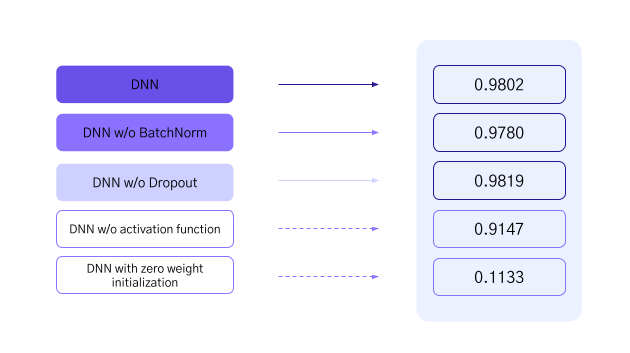

In [23]:
# 실험별 validation accuracy 최댓값
print(f"BatchNorm, Dropout 사용 모델: {scores['exp1']:.4f}")
print(f"BatchNorm 제거 모델: {scores['exp2']:.4f}")
print(f"Dropout 제거 모델: {scores['exp3']:.4f}")
print(f"Activation Function 제거 모델: {scores['exp4']:.4f}")
print(f"가중치를 0으로 초기화한 모델: {scores['exp5']:.4f}")

BatchNorm, Dropout 사용 모델: 0.9825
BatchNorm 제거 모델: 0.9782
Dropout 제거 모델: 0.9823
Activation Function 제거 모델: 0.9134
가중치를 0으로 초기화한 모델: 0.1133


## 2. 추론과 평가(inference & evaluation)

```
💡 목차 개요: 딥러닝 모델의 학습이 완료되었다면 모델의 성능을 평가해야 합니다. 학습한 모델을 통해 테스트 데이터에 대해 추론하고 다양한 메트릭으로 성능을 측정합니다.
```

- 2-1. 학습한 딥러닝 모델로 테스트 데이터 추론
- 2-2. 학습한 딥러닝 모델의 평가

In [24]:
# BatchNorm, Dropout을 사용한 모델을 로드합니다.
model = DNN(hidden_dims = hidden_dims, num_classes = 10, dropout_ratio = 0.2, apply_batchnorm = True, apply_dropout = True, apply_activation = True, set_super = True)
model.load_state_dict(torch.load("./model_exp1.pt"))
model = model.to(device)

### 2-1 학습한 딥러닝 모델로 테스트 데이터 추론

> 앞서 선언한 테스트 MNIST 데이터 셋에 대해 추론을 진행합니다.


In [25]:
model.eval()
total_labels = []
total_preds = []
total_probs = []
with torch.no_grad():
    for images, labels in test_dataloader:
        images = images.to(device)
        labels = labels

        outputs = model(images)
        # torch.max에서 dim 인자에 값을 추가할 경우, 해당 dimension에서 최댓값과 최댓값에 해당하는 인덱스를 반환
        _, predicted = torch.max(outputs.data, 1)

        total_preds.extend(predicted.detach().cpu().tolist())
        total_labels.extend(labels.tolist())
        total_probs.append(outputs.detach().cpu().numpy())

total_preds = np.array(total_preds)
total_labels = np.array(total_labels)
total_probs = np.concatenate(total_probs, axis= 0)

### 2-2 학습한 딥러닝 모델의 평가

> 모델이 예측한 결과값과 라벨을 사용하여 모델의 성능을 평가합니다.


In [26]:
# precision, recall, f1를 계산합니다.
precision = precision_score(total_labels, total_preds, average='macro')
recall = recall_score(total_labels, total_preds, average='macro')
f1 = f1_score(total_labels, total_preds, average='macro')

# AUC를 계산합니다.
# 모델의 출력으로 nn.LogSoftmax 함수가 적용되어 결과물이 출력되게 됩니다. sklearn의 roc_auc_score 메서드를 사용하기 위해서는 단일 데이터의 클래스들의 확률 합은 1이 되어야 합니다. 이를 위해 확률 matrix에 지수 함수를 적용합니다.
total_probs = np.exp(total_probs)
auc = roc_auc_score(total_labels, total_probs, average='macro', multi_class = 'ovr')

print(f'Precision: {precision}, Recall: {recall}, F1 Score: {f1}, AUC: {auc}')

Precision: 0.9820544273452091, Recall: 0.9818587637935259, F1 Score: 0.9819382325928865, AUC: 0.9996605584439108


#Reference
- [early stopping 구현 코드](https://github.com/zhouhaoyi/Informer2020/blob/main/utils/tools.py)




## Required Package

> torch == 2.0.1

> torchvision == 0.15.2

> sklearn == 1.3.0

## 콘텐츠 라이선스

저작권 : <font color='blue'> <b> ©2023 by Upstage X fastcampus Co., Ltd. All rights reserved.</font></b>

<font color='red'><b>WARNING</font> : 본 교육 콘텐츠의 지식재산권은 업스테이지 및 패스트캠퍼스에 귀속됩니다. 본 콘텐츠를 어떠한 경로로든 외부로 유출 및 수정하는 행위를 엄격히 금합니다. </b>